In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
sns.set_theme()
mpl.rcParams["mathtext.fontset"]='cm'

In [3]:
d = pd.read_pickle("../Création du Dataset/dataset.pkl")
dataset = d.copy()

# Ajout de colonnes à valeurs numériques

In [4]:
def add_rank_numerical_value_columns(dataset):
    listRankCols = ['TOP0_RANK','TOP1_RANK','JGL0_RANK','JGL1_RANK','MID0_RANK','MID1_RANK','ADC0_RANK','ADC1_RANK','SUP0_RANK','SUP1_RANK']
    rankOrder = ['IRON','BRONZE','SILVER','GOLD','PLATINUM','DIAMOND','MASTER','GRANDMASTER','CHALLENGER']
    divisionOrder = ['IV','III','II','I']
    for col in listRankCols:
        rank = pd.DataFrame(dataset[col].tolist(),dataset.index,columns=['RANK','DIVISION','LP'])
        for i in range(len(rankOrder)):
            rank.loc[rank['RANK']==rankOrder[i], 'RANK'] = i

        for i in range(len(divisionOrder)):
            rank.loc[rank['DIVISION']==divisionOrder[i], 'DIVISION'] = i
        
        dataset[col+'_NUM'] = rank['RANK']*400 + rank['DIVISION']*100 + rank['LP']

In [5]:
add_rank_numerical_value_columns(dataset)

In [6]:
def add_kda_ratio_columns(dataset):
    listRankCols = ['TOP0_KDAG','TOP1_KDAG','JGL0_KDAG','JGL1_KDAG','MID0_KDAG','MID1_KDAG','ADC0_KDAG','ADC1_KDAG','SUP0_KDAG','SUP1_KDAG']
    for col in listRankCols:
        top0KDA = pd.DataFrame(dataset[col].tolist(),dataset.index,columns=['K','D','A'])
        dataset[col+'_RATIO'] = (top0KDA['K'] + top0KDA['A']) / (top0KDA['D']+1)

In [7]:
add_kda_ratio_columns(dataset)

# Step-by-step : Analyse de corrélation entre le nombre de games et le winrate sur la saison entière

## 1. Distribution

In [8]:
nbGames = list(dataset[['TOP0_TOTAL','TOP1_TOTAL','JGL0_TOTAL','JGL1_TOTAL','MID0_TOTAL','MID1_TOTAL','ADC0_TOTAL','ADC1_TOTAL','SUP0_TOTAL','SUP1_TOTAL']].stack())
winrate = list(dataset[['TOP0_GWR','TOP1_GWR','JGL0_GWR','JGL1_GWR','MID0_GWR','MID1_GWR','ADC0_GWR','ADC1_GWR','SUP0_GWR','SUP1_GWR']].stack())
data = pd.DataFrame(zip(nbGames,winrate),columns=["Nombre de Games","Winrate"])

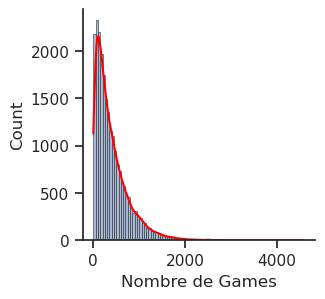

In [9]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(3, 3))
sns.despine(f)
sns.histplot(data, x="Nombre de Games", binwidth=50, kde=True, edgecolor=".3", linewidth=.5).lines[0].set_color('red')

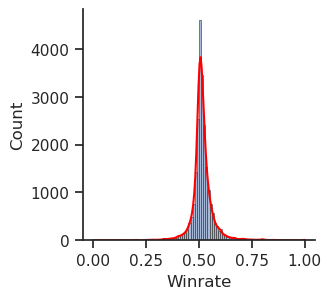

In [10]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(3, 3))
sns.despine(f)
sns.histplot(data, x="Winrate", binwidth=0.01, edgecolor=".3", linewidth=.5, kde=True).lines[0].set_color('red')

## 2. Élimination des outliers

In [11]:
data.drop(data[(data["Winrate"] > 0.65) | (data["Winrate"] < 0.35)].index, inplace=True)
data.drop(data[(data["Nombre de Games"] > 1500) | (data["Nombre de Games"] < 20)].index, inplace=True)

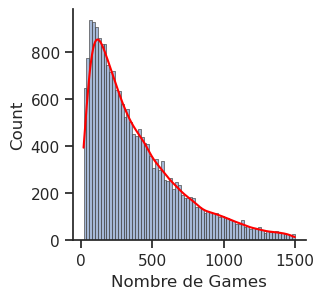

In [12]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(3, 3))
sns.despine(f)
sns.histplot(data, x="Nombre de Games", binwidth=20, edgecolor=".3", linewidth=.5, kde=True).lines[0].set_color('red')

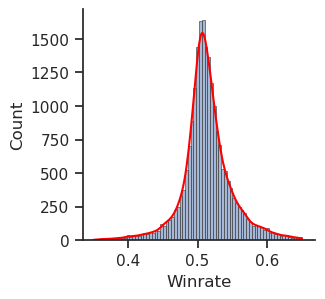

In [13]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(3, 3))
sns.despine(f)
sns.histplot(data, x="Winrate", binwidth=0.004, edgecolor=".3", linewidth=.5, kde=True).lines[0].set_color('red')

## 3. Plotting des valeurs

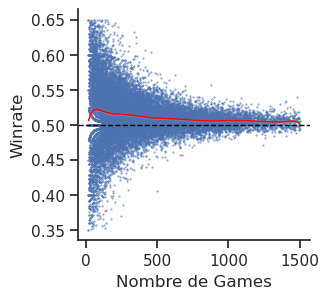

In [14]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(3, 3))
sns.despine(f)
sns.regplot(data=data, x="Nombre de Games", y="Winrate",order=12, scatter_kws={"s":0.2}, line_kws={"color": "red","linewidth":1})
plt.axhline(y=0.5, color="black", linestyle="--", linewidth=1)

## 4. Analyse de corrélation

In [15]:
from scipy.stats.stats import pearsonr

r,p = pearsonr(data["Nombre de Games"], data["Winrate"])
print(f"{r=:.04f}\n{p=}")

r=-0.1275
p=1.300767441183645e-78


## 5. Résumé en une fonction 
#### (bon en fait le code est pas exactement pareil, il est mieux, mais le principe reste le même)

In [16]:
from matplotlib.gridspec import GridSpec
from scipy.stats import linregress

def correlation(dataset, colNameX, colNameY, displayNameX=None, displayNameY=None):
    if displayNameX is None : displayNameX = colNameX
    if displayNameY is None : displayNameY = colNameY
    
    # On récupère les données intéressantes
    listPos = ['TOP0_','TOP1_','JGL0_','JGL1_','MID0_','MID1_','ADC0_','ADC1_','SUP0_','SUP1_']
    listX = [pos + colNameX for pos in listPos]
    listY = [pos + colNameY for pos in listPos]
    dataX = list(dataset[listX].stack())
    dataY = list(dataset[listY].stack())
    data = pd.DataFrame(zip(dataX,dataY),columns=[displayNameX,displayNameY])
    
    # On enlève les valeurs extrêmes
    data.drop(data[(data[displayNameX] > data[displayNameX].quantile(0.99)) | (data[displayNameX] < data[displayNameX].quantile(0.01))].index, inplace=True)
    data.drop(data[(data[displayNameY] > data[displayNameY].quantile(0.99)) | (data[displayNameY] < data[displayNameY].quantile(0.01))].index, inplace=True)
    
    # Setup du plot
    sns.set_theme(style="ticks")
    gs = GridSpec(2, 2)
    fig = plt.figure(figsize=(10,8))
    ax = [fig.add_subplot(pos) for pos in [gs[0,0], gs[0,1], gs[1,:]]]
    sns.despine(fig)
    fig.subplots_adjust(hspace=0.5, wspace=0.25)
    
    maxX = data[displayNameX].max()
    minX = data[displayNameX].min()
    maxY = data[displayNameY].max()
    minY = data[displayNameY].min()
    
    # Plots
    sns.histplot(data, x=displayNameX, binwidth=(maxX-minX)/50, edgecolor=".3", linewidth=.25, ax=ax[0], kde=True).lines[0].set_color('orangered')
    sns.histplot(data, x=displayNameY, binwidth=(maxY-minY)/50, edgecolor=".3", linewidth=.25, ax=ax[1], kde=True).lines[0].set_color('orangered')
    sns.scatterplot(data=data, x=displayNameX, y=displayNameY, s = 1.2, ax=ax[2])
    
    # Cas spécial pour le winrate : on affiche une ligne en pointillé à 50% de winrate pour une meilleure lecture
    if colNameY == "GWR":
        ax[2].axhline(y=0.5, color="black", linestyle="--", linewidth=1)
    
    # Régression linéaire / Calcul du coeff de Pearson (c'est r)
    a, b, r, p, s = linregress(x=data[displayNameX],y=data[displayNameY])
    ax[2].plot([minX,maxX],[a*minX+b,a*maxX+b], color="red")
        
    bboxprops = dict(boxstyle="round", facecolor="white", edgecolor="0.5", alpha=0.4)
    ax[2].text(maxX,maxY,f"Coef. de corrélation : $r = {r:.3g}$\np value : $p = {p:.3g}$\nErreur type : $s = {s:.3g}$", horizontalalignment="right", verticalalignment="top", fontsize=12, bbox=bboxprops)
    aexp = np.floor(np.log10(np.abs(a)))
    ax[2].text(maxX,minY,f"Régression linéraire :\n$f(x) = {a/(10**aexp):.3g}\cdot10^{{{aexp}}}x+{b:.3g}$", horizontalalignment="right", verticalalignment="bottom", fontsize=12, bbox=bboxprops)

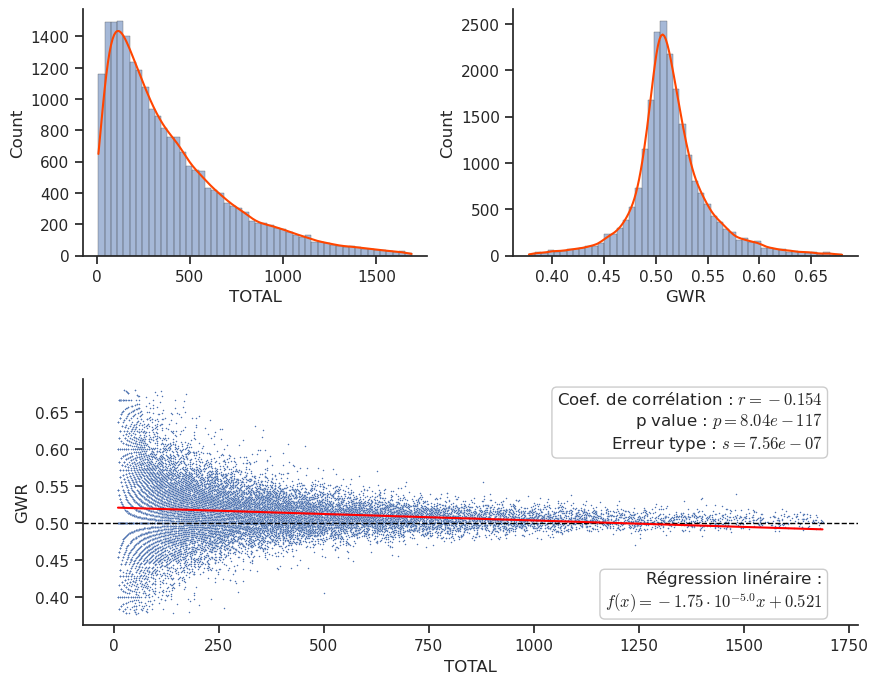

In [17]:
correlation(dataset, 'TOTAL', 'GWR')

# Analyse de corrélation pour d'autres valeurs

### (Toujours par rapport au winrate sur la saison entière)

Attention à l'interprétation de ces informations. 

Il faut garder à l'esprit que le dataset est centré sur le niveau Platine.

Il faut aussi faire la distinction des informations liées à la partie et des informations liées aux joueurs. Ces dernières ont évoluées depuis la partie enregistrée dans le dataset, il faut donc faire attention à la façon dont on les utilise.

Un point positif est qu'étant donné qu'on est à la fin de la saison, les valeurs comme le rang d'un joueur sont proches du niveau réel de ce dernier, ce qui n'aurait pas été le cas en début ou milieu de saison. Par contre, le rang est en réalité le 'rang en fin de saison' et pas le 'rang lors de la partie'.

## 1. Niveau d'invocateur

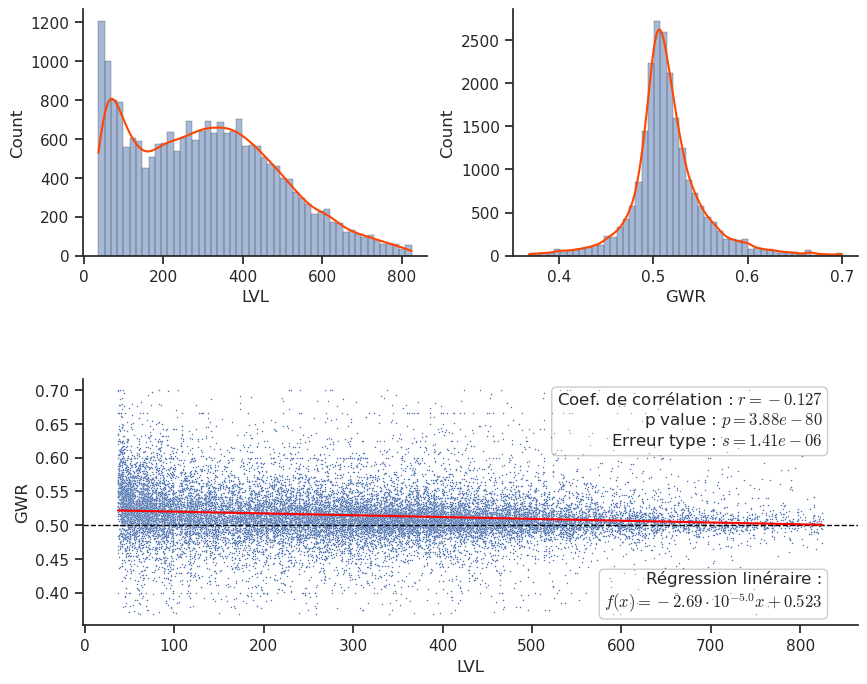

In [18]:
correlation(dataset, 'LVL', 'GWR')

## 2. KDA sur les 5 dernières parties

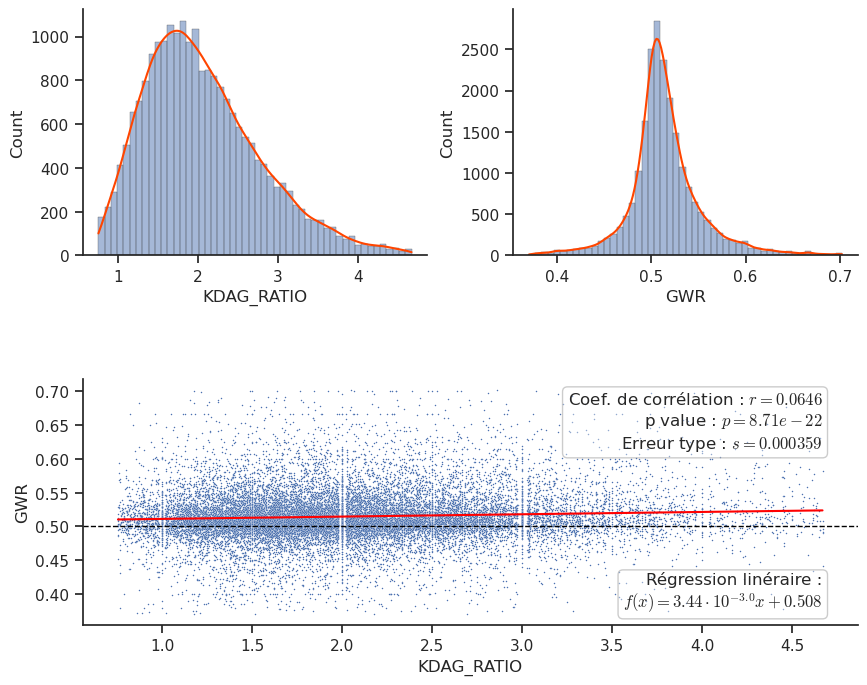

In [19]:
correlation(dataset, 'KDAG_RATIO', 'GWR')

## 3. Rang du joueur

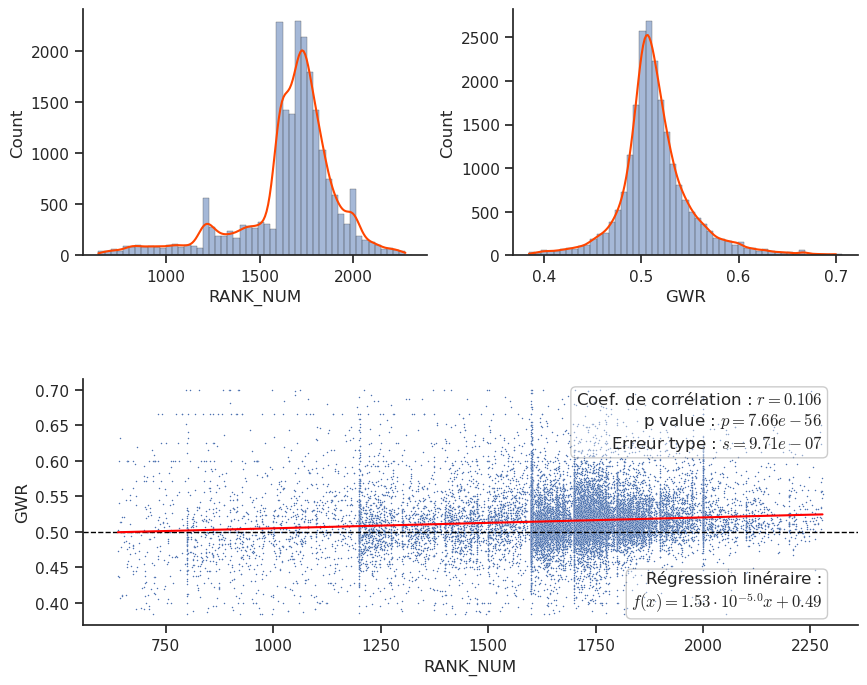

In [20]:
correlation(dataset, 'RANK_NUM', 'GWR')

# Bonus : Rang en fonction du nombre de parties et en fonction du niveau d'invocateur

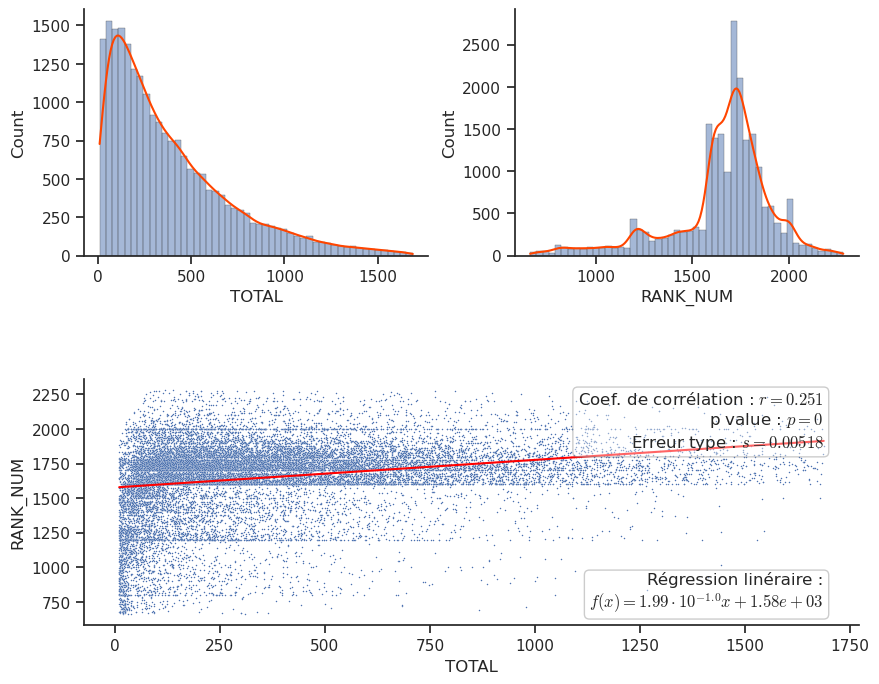

In [21]:
correlation(dataset, 'TOTAL', 'RANK_NUM')

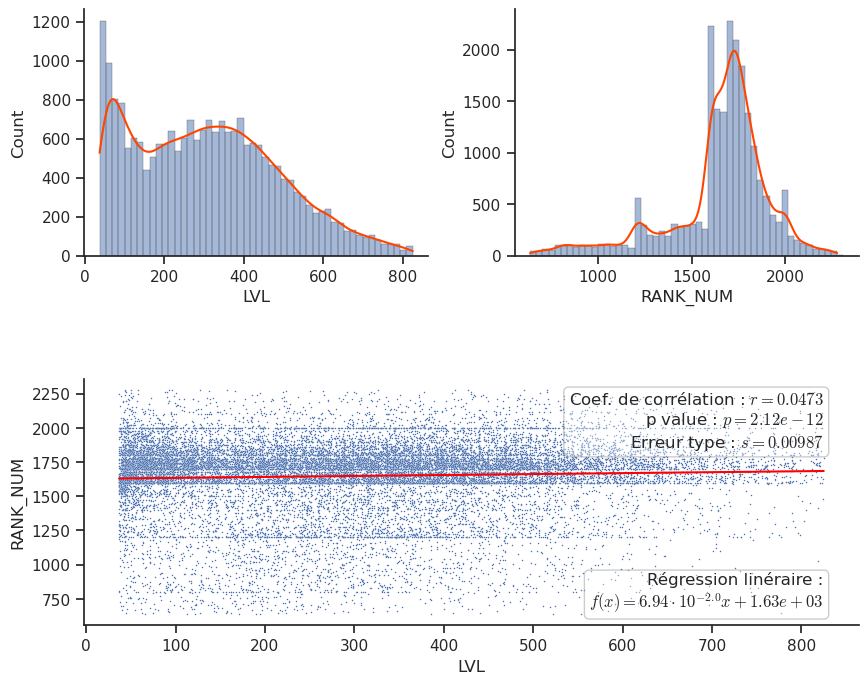

In [22]:
correlation(dataset, 'LVL', 'RANK_NUM')